#### Import

In [74]:
import pandas as pd
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import joblib
from datetime import datetime
import random
from faker import Faker
from elasticsearch import Elasticsearch




nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Mise en forme des caractéres : tout en minuscule, suppression de la ponctuation et des chiffres 

In [75]:
df = pd.read_csv("Emotion_final.csv")
df = df.apply(lambda x: x.astype(str).str.lower())
df['Text'] = df['Text'].str.replace('[{}\d]'.format(string.punctuation), '', regex=True)

In [76]:
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,melissa stared at her friend in dism,fear
21455,successive state elections have seen the gover...,fear
21456,vincent was irritated but not dismay,fear
21457,kendallhume turned back to face the dismayed coup,fear


## Analyse des données

In [77]:
df.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


### Suppression des doublons

In [78]:
dup = df.duplicated()
dup.value_counts()

False    21456
True         3
dtype: int64

In [79]:
df = df.drop_duplicates(keep='last')

In [80]:
df.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [81]:
df.Emotion.value_counts()

happy       7028
sadness     6265
anger       2992
fear        2651
love        1641
surprise     879
Name: Emotion, dtype: int64

### Stopwords

In [82]:
stops = set(stopwords.words('english'))
nv_mots_stops = ['feel', 'feeling','feelings', 'look', 'days','life','like','im','really', 'see', 'life', 'today','didnt','go', 'know', 'get', 'want', 'would', 'time', 'little', 'ive', 'still', 'even', 'one',  'people', 'think', 'bit', 'things', 'much', 'dont', 'make', 'day', 'something', 'back', 'going', 'way', 'could']
stops.update(nv_mots_stops)

### Les 30 mots les plus frequents par sentiments

In [83]:
def top_30_mots(texts, n=30):
    mots = []
    for text in texts:
        for mot in text.split():
            if mot.isalpha() and mot not in stops:
                mots.append(mot)
    mot_freq = {mot: mots.count(mot) for mot in set(mots)}
    top_mots = sorted(mot_freq.items(), key=lambda x: x[1], reverse=True)[:n]
    return top_mots

sentiments = ['sadness', 'anger', 'love', 'surprise', 'fear', 'happy']

top_mots_par_sentiment = {}

for sentiment in sentiments:
    texts = df[df['Emotion'] == sentiment]['Text']
    top_mots = top_30_mots(texts)
    top_mots_par_sentiment[sentiment] = top_mots



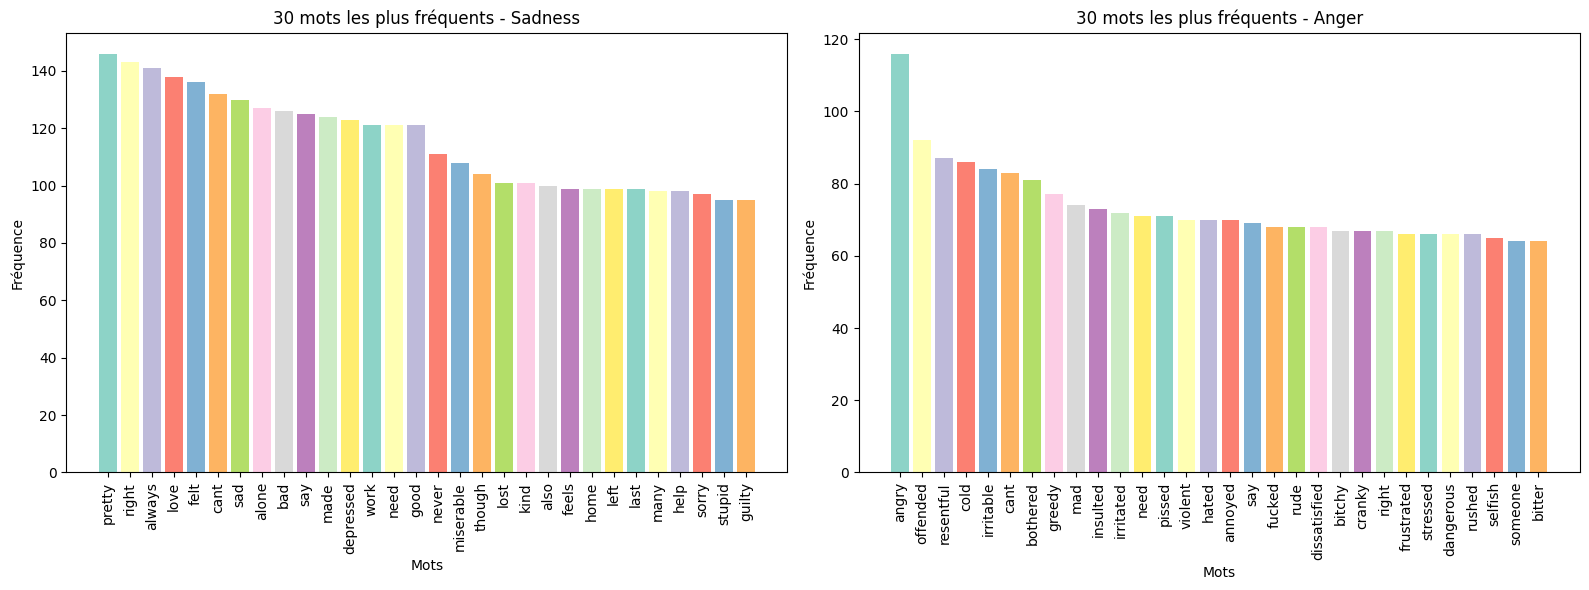

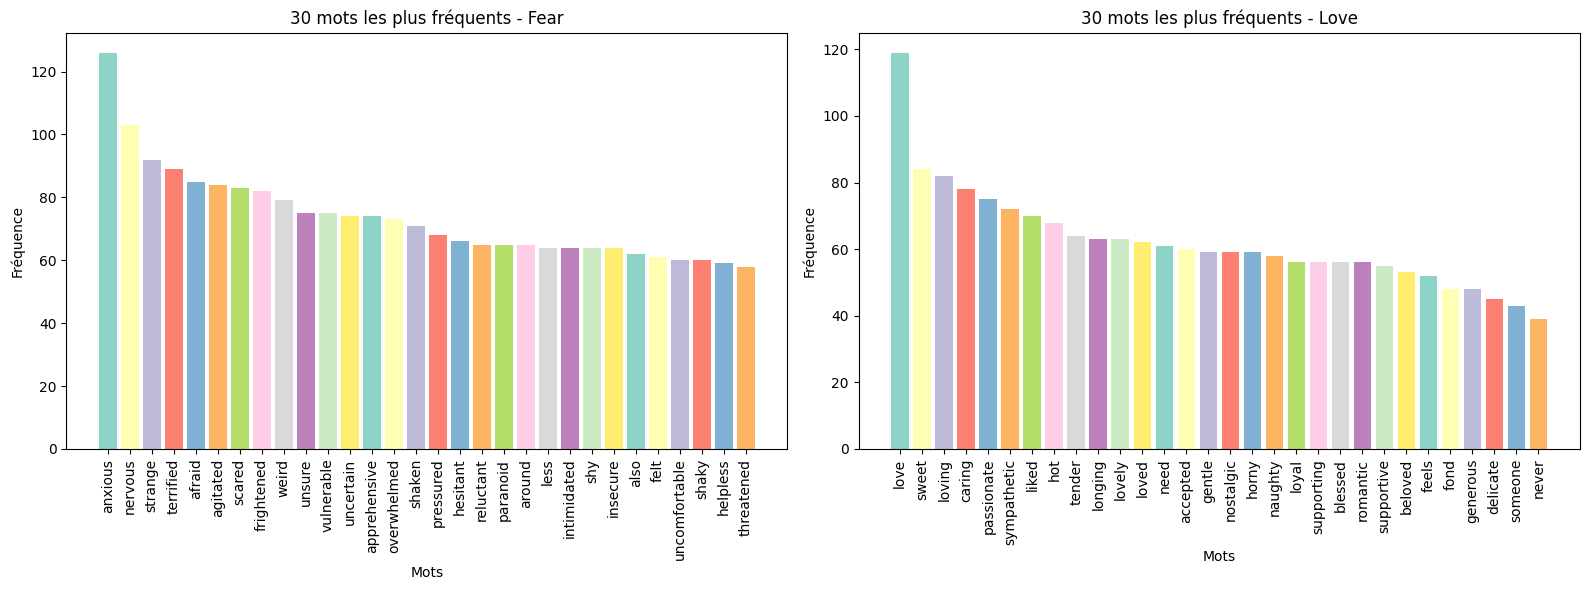

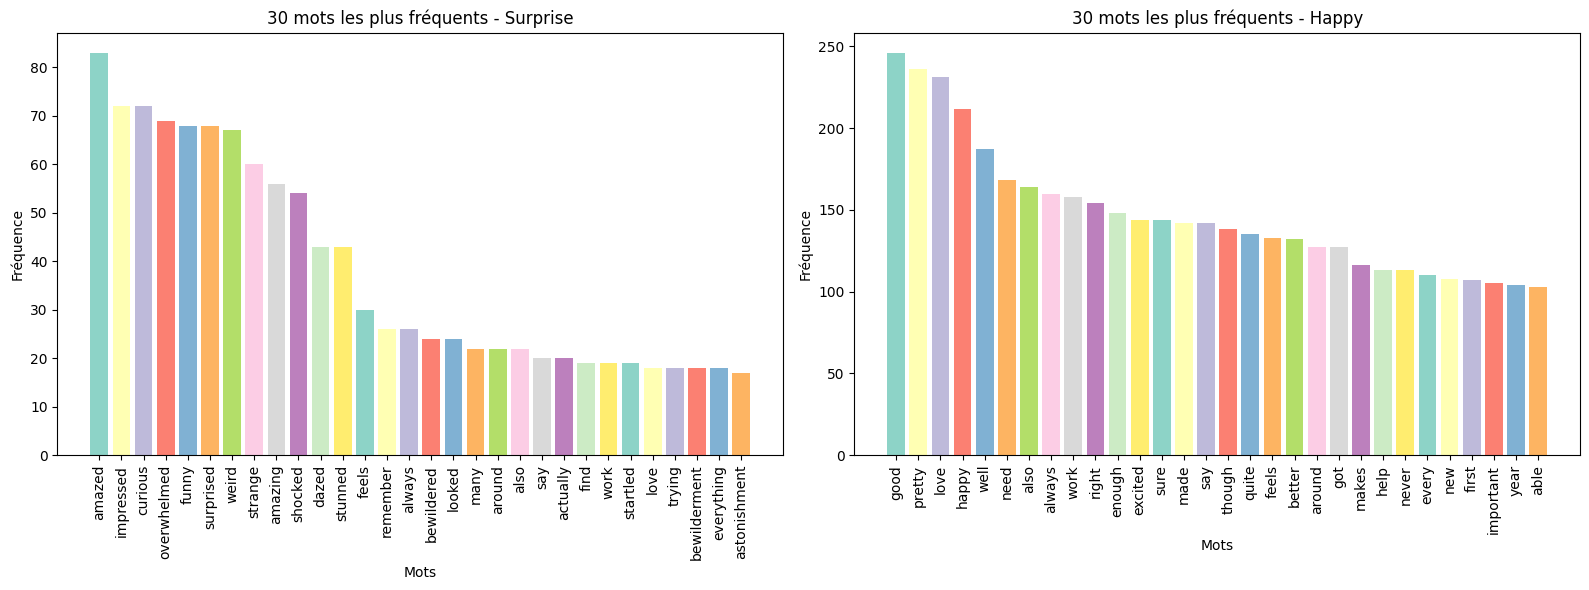

In [84]:
emotions1 = ["sadness", "anger"]
emotions2 = ["fear", "love"]
emotions3 = ["surprise", "happy"]

fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, emotion in enumerate(emotions1):
    top_mots_emotion = top_mots_par_sentiment[emotion]
    df1 = pd.DataFrame(top_mots_emotion, columns=["Mots", "Fréquence"])
    couleurs = sns.color_palette("Set3", len(df1))
    axes1[i].bar(df1["Mots"], df1["Fréquence"], color=couleurs)
    axes1[i].set_xlabel("Mots")
    axes1[i].set_ylabel("Fréquence")
    axes1[i].set_title(f"30 mots les plus fréquents - {emotion.capitalize()}")
    axes1[i].tick_params(axis='x', rotation=90)

fig1.tight_layout()

fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, emotion in enumerate(emotions2):
    top_mots_emotion = top_mots_par_sentiment[emotion]
    df1 = pd.DataFrame(top_mots_emotion, columns=["Mots", "Fréquence"])
    couleurs = sns.color_palette("Set3", len(df1))
    axes2[i].bar(df1["Mots"], df1["Fréquence"], color=couleurs)
    axes2[i].set_xlabel("Mots")
    axes2[i].set_ylabel("Fréquence")
    axes2[i].set_title(f"30 mots les plus fréquents - {emotion.capitalize()}")
    axes2[i].tick_params(axis='x', rotation=90)

fig2.tight_layout()

fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, emotion in enumerate(emotions3):
    top_mots_emotion = top_mots_par_sentiment[emotion]
    df1 = pd.DataFrame(top_mots_emotion, columns=["Mots", "Fréquence"])
    couleurs = sns.color_palette("Set3", len(df1))
    axes3[i].bar(df1["Mots"], df1["Fréquence"], color=couleurs)
    axes3[i].set_xlabel("Mots")
    axes3[i].set_ylabel("Fréquence")
    axes3[i].set_title(f"30 mots les plus fréquents - {emotion.capitalize()}")
    axes3[i].tick_params(axis='x', rotation=90)

fig3.tight_layout()

plt.show()

### HeatMap des mots les plus frequents par sentiment

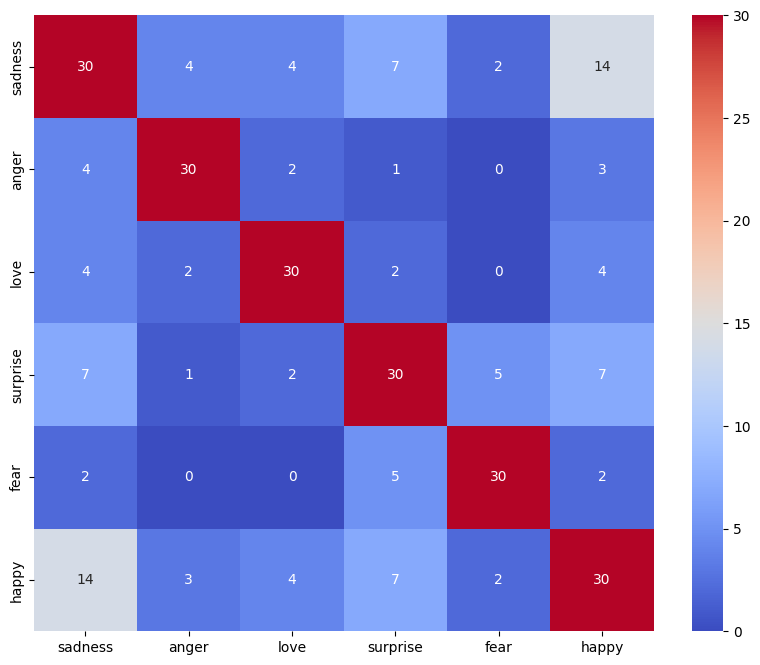

In [85]:
matrice = pd.DataFrame(index=sentiments, columns=sentiments)

for sentiment1 in sentiments:
    for sentiment2 in sentiments:
        mots1 = set(mot for mot, _ in top_mots_par_sentiment[sentiment1])
        mots2 = set(mot for mot, _ in top_mots_par_sentiment[sentiment2])
        mots_commmun = len(mots1 & mots2)
        matrice.loc[sentiment1, sentiment2] = mots_commmun

matrice = matrice.astype(int)   


plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, cmap='coolwarm')
plt.show()

    Pour chaque sentiment on calcule le nombre de mots en commun entre les 30 mots les plus fréquents en convertissant les listes de mots en ensemble. Ensuite on compte les mots qui apparaissent dans les deux set. Le nombre de mots en commun est ensuite affiché dans la matrice

## Modélisation
### Bag Of Words : LogisticRegression

In [86]:
nltk.download('punkt')
nltk.download('wordnet')

stops = list(stops)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    return ' '.join(lemmatizer.lemmatize(term) for term in word_tokenize(text.lower()) if term not in stops)

X = df['Text'].apply(preprocess_text)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words=stops)),
    ('clf', LogisticRegression()),# Meilleur paramétres C=20.52695741523762, max_iter=186, solver='saga', penalty='l1'
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds).round(2))

[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy:  0.89


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### TFIDF : RandomForestClassifier  

In [87]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stops = list(stops)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    return ' '.join(lemmatizer.lemmatize(term) for term in word_tokenize(text.lower()) if term not in stops)

X = df['Text'].apply(preprocess_text)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stops)),
    ('clf', RandomForestClassifier()),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds).round(2))

joblib.dump(pipeline, 'model_tfidf.joblib')

[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy:  0.89


['model_tfidf.joblib']

## Stocker les données avec ElasticSearch

### Mise en place

- docker run -d -p 9200:9200 -v /usr/share/elasticsearch/data -e "discovery.type=single-node" --name elastic docker.elastic.co/elasticsearch/elasticsearch:7.17.10
- docker logs elastic
- curl http://localhost:9200/


### Creation BDD
### Mapper et importer les données 

In [88]:
es = Elasticsearch(hosts=["http://localhost:9200"])



model = joblib.load('model_tfidf.joblib')
fake = Faker()
es.indices.delete(index="notes")

/tmp/ipykernel_7696/1975348744.py:7: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.delete(index="notes")


ObjectApiResponse({'acknowledged': True})

In [89]:


mapping = {
    "mappings": {
        "properties": {
            "patient_lastname": {"type": "keyword"},
            "patient_firstname": {"type": "keyword"},
            "text": {"type": "text", "analyzer": "standard"},
            "date": {"type": "date"},
            "patient_left": {"type": "boolean"},
            "emotion": {"type": "keyword"},
            "confidence": {"type": "float"}
        }
    }
}

es.indices.create(index="notes", body=mapping)

csv_df = pd.read_csv('Emotion_final.csv')

patient_names = []
for _ in range(200):
    patient_names.append((fake.last_name(), fake.first_name()))

for i in range(csv_df.shape[0]):
    patient_lastname, patient_firstname = patient_names[i % 200]
    text = csv_df['Text'].iloc[i]
    date = fake.date_between(start_date='-1y', end_date='today')
    patient_left = fake.boolean()

    processed_text = preprocess_text(text)

    emotion = model.predict([processed_text])[0]
    confidence = model.predict_proba([processed_text])[0].max()

    document = {
        "patient_lastname": patient_lastname,
        "patient_firstname": patient_firstname,
        "text": text,
        "date": date,
        "patient_left": patient_left,
        "emotion": emotion,
        "confidence": confidence
    }

    es.index(index="notes", body=document)



/tmp/ipykernel_7696/284450458.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index="notes", body=mapping)
/tmp/ipykernel_7696/284450458.py:15: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index="notes", body=mapping)
/tmp/ipykernel_7696/284450458.py:44: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index="notes", body=document)
/tmp/ipykernel_7696/284450458.py:44: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, yo

## Requetes

### Aboutir à un data frame permettant d’afficher la répartition des sentiments, des textes pour un patient en utilisant son nom / prenom


In [ ]:
result = es.search(index='notes', body={
    "query": {
        "bool": {
            "must": [
                {"term": {"patient_lastname": "Moon"}},
                {"term": {"patient_firstname": "Caroline"}}
            ]
        }
    },
    "_source": ["emotion", "text"], 
})

sentiments = [doc['_source']['emotion'] for doc in result['hits']['hits']]
texts = [doc['_source']['text'] for doc in result['hits']['hits']]

df_moon = pd.DataFrame({"Sentiment": sentiments, "Text": texts})


/tmp/ipykernel_7696/452064032.py:1: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index='notes', body={
/tmp/ipykernel_7696/452064032.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index='notes', body={


In [ ]:
df_moon

,Sentiment,Text


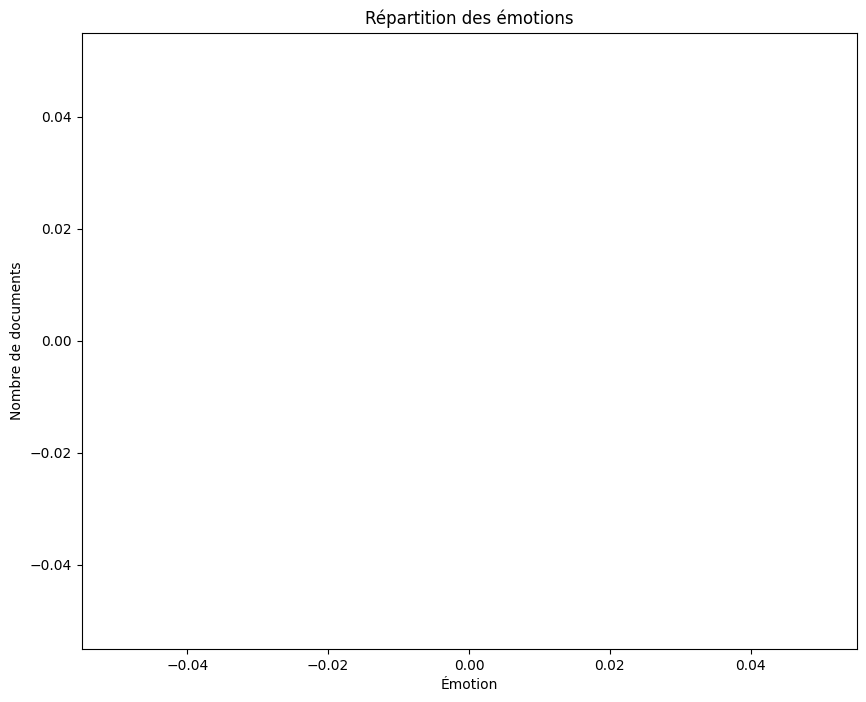

In [ ]:

nb_emotion = df_moon['Sentiment'].value_counts()

plt.figure(figsize=(10, 8))
plt.bar(nb_emotion.index, nb_emotion.values)
plt.xlabel('Émotion')
plt.ylabel('Nombre de documents')
plt.title('Répartition des émotions')
plt.show()


### Parmi les documents classifiés comme happy, quel pourcentage contient le mot "sadness", "fear", "anger", "love", "surprise" 


/tmp/ipykernel_4787/231331024.py:1: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  reponse = es.search(
/tmp/ipykernel_4787/231331024.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  reponse = es.search(
/tmp/ipykernel_4787/231331024.py:19: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  reponse = es.scroll(


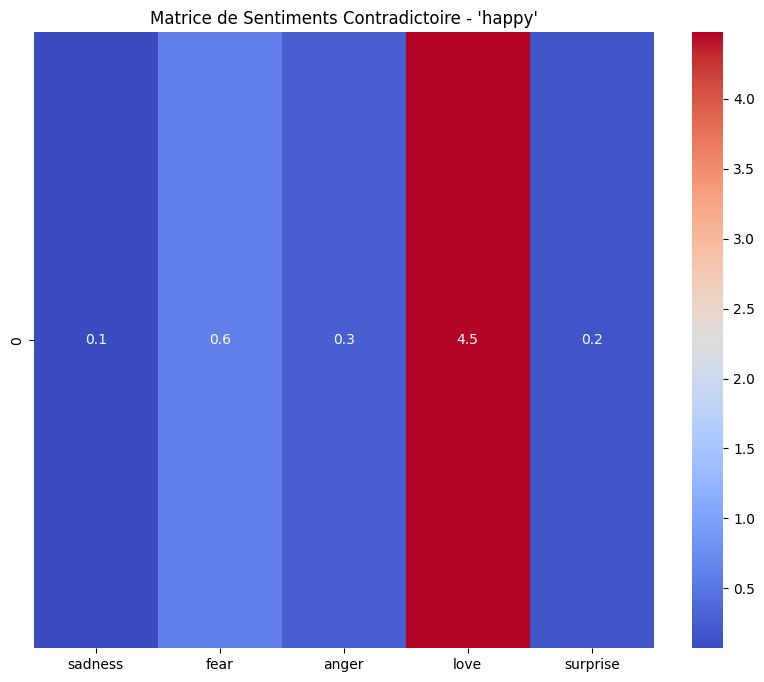

In [ ]:
reponse = es.search(
    index="notes",
    body={
        "query": {
            "term": {
                "emotion": "happy"
            }
        },
        "size": 100  
    },
    scroll="2m"  
)

scroll_id = reponse["_scroll_id"]

happy_documents = [hit["_source"]["text"] for hit in reponse["hits"]["hits"]]

while len(reponse["hits"]["hits"]) > 0:
    reponse = es.scroll(
        scroll_id=scroll_id,
        scroll="2m"  
    )
    happy_documents += [hit["_source"]["text"] for hit in reponse["hits"]["hits"]]

mot_cles = ["sadness", "fear", "anger", "love", "surprise"]

nb_mots_cle = {}
for mot_cle in mot_cles:
    compte = sum(mot_cle.lower() in document.lower() for document in happy_documents)
    nb_mots_cle[mot_cle] = compte

doc_total = len(happy_documents)
mot_cle_pourcentage = {mot_cle: (compte / doc_total) * 100 for mot_cle, compte in nb_mots_cle.items()}

data = [[mot_cle_pourcentage[mot_cle] for mot_cle in mot_cles]]

plt.figure(figsize=(10, 8))
sns.heatmap(data, cmap="coolwarm", annot=True, fmt=".1f", xticklabels=mot_cles)
plt.title("Matrice de Sentiments Contradictoire - 'happy'")
plt.show()


### Pour chacune des étapes du deuil (denial, anger, bargaining, depression, acceptance) rechercher le nombre de text correspondants 
### A l’aide d’une recherche pleine


In [ ]:
deuil = ["denial", "anger", "bargaining", "depression", "acceptance"]
nombre_de_texts = {}

for stage in deuil:
    result = es.search(index="notes", body={
        "query": {
            "match": {
                "text": stage
            }
        },
        "size": 0
    })
    total_hits = result['hits']['total']['value']
    nombre_de_texts[stage] = total_hits

print(nombre_de_texts)


{'denial': 2, 'anger': 66, 'bargaining': 0, 'depression': 23, 'acceptance': 9}


/tmp/ipykernel_4787/1254525193.py:5: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index="notes", body={
/tmp/ipykernel_4787/1254525193.py:5: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index="notes", body={


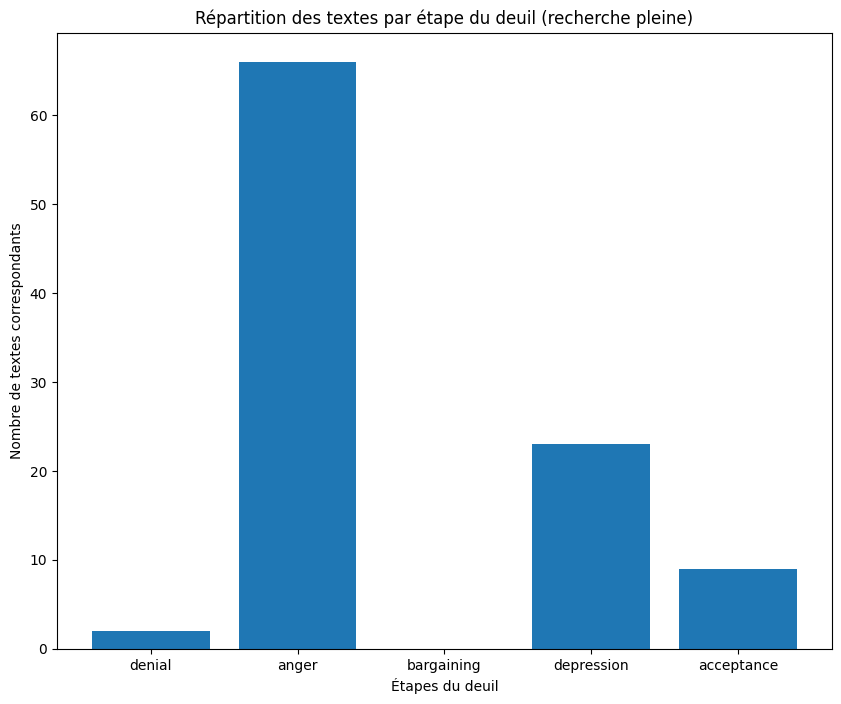

In [ ]:
deuil = list(nombre_de_texts.keys())
nombre_de_texts_values = list(nombre_de_texts.values())


plt.figure(figsize=(10, 8))
plt.bar(deuil, nombre_de_texts_values)
plt.xlabel("Étapes du deuil")
plt.ylabel("Nombre de textes correspondants")
plt.title("Répartition des textes par étape du deuil (recherche pleine)")
plt.show()


### A l'aide d’une recherche fuzzy

In [ ]:
nombre_de_texts1 = {}

for stage in deuil:
    result = es.search(index="notes", body={
        "query": {
            "fuzzy": {
                "text": {
                    "value": stage,
                    "fuzziness": "AUTO"
                }
            }
        },
        "size": 0
    })
    total_hits = result['hits']['total']['value']
    nombre_de_texts1[stage] = total_hits

print(nombre_de_texts1)

{'denial': 119, 'anger': 82, 'bargaining': 0, 'depression': 84, 'acceptance': 71}


/tmp/ipykernel_4787/409689603.py:4: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index="notes", body={
/tmp/ipykernel_4787/409689603.py:4: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index="notes", body={


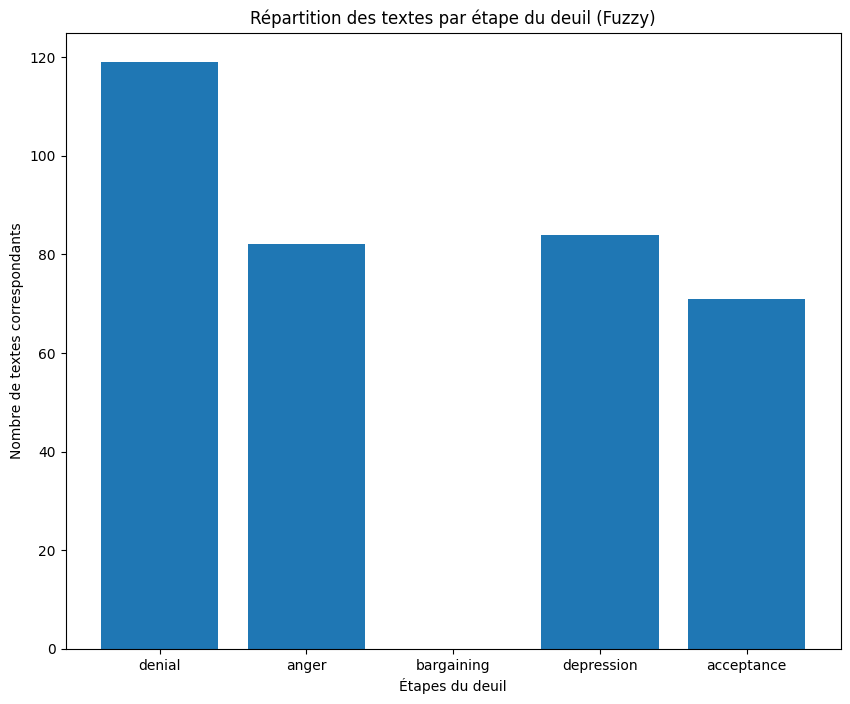

In [ ]:
deuil1 = list(nombre_de_texts1.keys())
nombre_de_texts_values1 = list(nombre_de_texts1.values())


plt.figure(figsize=(10, 8))
plt.bar(deuil1, nombre_de_texts_values1)
plt.xlabel("Étapes du deuil")
plt.ylabel("Nombre de textes correspondants")
plt.title("Répartition des textes par étape du deuil (Fuzzy)")
plt.show()

### Rechercher les textes:
- qui matchent avec l’expression “good day” (must)
- chez les patients encore en consultation (filter)
- qui contiennent si possible “to rest” (should)
- qui ne doivent pas avoir seuil de confiance inférieur à 0.5 s’il existe


In [ ]:
result = es.search(index='notes', body={
    "query": {
        "bool": {
            "must": [
                {"match": {"text": "good day"}}
            ],
            "filter": [
                {"term": {"patient_left": False}}
            ],
            "should": [
                {"match": {"text": "to rest"}}
            ],
            "must_not": [
                {"range": {"confidence": {"lt": 0.5}}}
            ]
        }
    },
    "_source": ["text", "emotion","patient_firstname","patient_firstname",'patient_lastname']
})

hits = result['hits']['hits']
data = [(hit['_source']['text'], hit['_source']['emotion'],hit['_source']['patient_firstname'],hit['_source']['patient_lastname']) for hit in hits]
df_search_text = pd.DataFrame(data, columns=["Text", "Emotion","patient_firstname",'patient_lastname'])


/tmp/ipykernel_4787/3690745101.py:1: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index='notes', body={
/tmp/ipykernel_4787/3690745101.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index='notes', body={


In [ ]:
df_search_text

,Text,Emotion,patient_firstname,patient_lastname
0,i end up feeling exhausted for all the rest of...,sadness,Jessica,Castro
1,i either feel like crap about myself all day a...,sadness,Terrance,Silva
2,im trying to give it my good old space feeling...,happy,Charles,Howard
3,i end up feeling groggy the rest of the day am...,sadness,Alexander,Lopez
4,i am off on wednesday to a postgraduate open d...,happy,Willie,Hendricks
5,i was feeling pretty anxious all day but my fi...,fear,Linda,Gibbs
6,i worked out monday and tuesday but i was feel...,sadness,Keith,Henderson
7,i know that obrian can do good characterisatio...,anger,Nathan,Olson
8,i remember laying in the bath feeling really e...,sadness,Michael,Grant
9,i do finally get some sleep i have the crazies...,happy,Makayla,Little


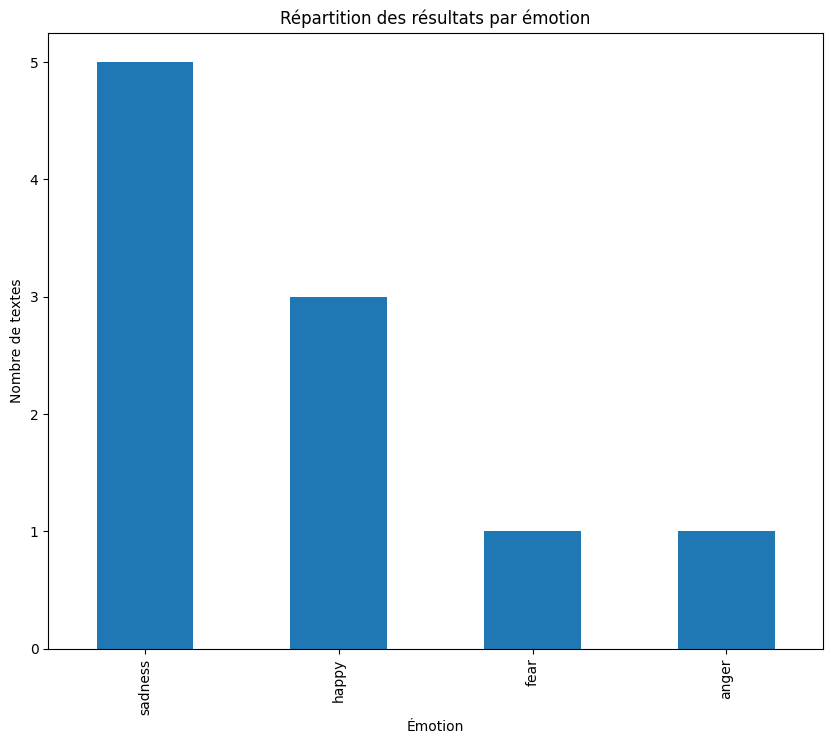

In [ ]:
compte_emotion = df_search_text["Text"].apply(lambda text: model.predict([preprocess_text(text)])[0]).value_counts()

plt.figure(figsize=(10, 8))
compte_emotion.plot(kind="bar")
plt.xlabel("Émotion")
plt.ylabel("Nombre de textes")
plt.title("Répartition des résultats par émotion")
plt.show()


## Questions théoriques

### Qu’est ce que le sharding?
    Le sharding est un concept pour diviser les données en plusieurs fragments appelés shards. Chaque shard est une partie  autonome de la base de données, contenant un sous-ensemble des données.
    C'est souvent utile pour les gros index, afin de les découper en plus petits morceaux.
    Le plus judicieux est de crée des shards en fonctions des recherches qu'on utilise les plus fréquement

### Comment pourrait-on imaginer un sharding sur cet index?
    Nous aurions pu imaginer un sharding basé sur un champ  "patient_lastname" ou "patient_firstname" pour répartir les données sur différents shards. pour  garantir que tous les documents d'un même patient seraient stockés dans le même shard.
    Dans la même optique imaginer un sharding basé sur les émotions pour regrouper les documents de patients ayant des émotions similaires dans un même shard. Ca pourrait faciliter l'analyse et le traitement des données, en permettant de travailler spécifiquement sur des groupes de patients partageant des émotions communes.

### Quels ingestion pipelines seraient pertinents pour notre sujet
    Pour prédire des émotions à partir de texte, voici les exemples d'ingestion de pipeline qui pourraient être pertinents:
    
    - Normalisation du texte : suppression de la ponctuation, la conversion en minuscules, la suppression des accents, des chiffres etc.
    - Tokenization : pour diviser le texte en mots pour capturer les informations importantes pour l'analyse des émotions.
    - Les Stop words : pour supprimer les mots courants qui n'apportent pas de valeur significative au texte, afin d'améliorer la précision des prédictions.    
    - Lemmatization : pour réduire les mots à leur racine et améliorer la cohérence dans l'analyse des émotions.

## Alternative

### Intégrer la gestion des stopwords au niveau du Mapping

In [ ]:
# mapping={
#   "settings": {
#     "analysis": {
#       "analyzer": {
#         "stopword_analyzer": {
#           "type": "custom",
#           "tokenizer": "standard",
#           "filter": ["lowercase", "english_stop"]
#         }
#       },
#       "filter": {
#         "english_stop": {
#           "type": "stop",
#           "stopwords": "_english_"
#         }
#       }
#     }
#   },
#   "mappings": {
#     "properties": {
#       "patient_lastname": {"type": "keyword"},
#       "patient_firstname": {"type": "keyword"},
#       "text": {
#         "type": "text",
#         "analyzer": "stopword_analyzer"
#       },
#       "date": {"type": "date"},
#       "patient_left": {"type": "boolean"},
#       "emotion": {"type": "keyword"},
#       "confidence": {"type": "float"}
#     }
#   }
# }


### Intégrer le modèle de ML comme ingest pipeline

In [ ]:
# """PUT _ingest/pipeline/emotion_pipeline"""
# {
#   "description" : "Pipeline to predict emotion and confidence",
#   "processors" : [
#     {
#       "script" : {
#         "source" : """
#           def processed_text = ctx.text;

#           def emotion = model.predict([processed_text])[0];
#           def confidence = model.predict_proba([processed_text])[0].max();

#           ctx.emotion = emotion;
#           ctx.confidence = confidence;
#         """,
#         "lang" : "painless",
#         "params" : {
#           "model" : "model_tfidf.joblib" 
#         }
#       }
#     }
#   ]
# }

# ####################################################################
# ######################### RESTE DU CODE ############################
# ####################################################################

# document = {
#     "patient_lastname": patient_lastname,
#     "patient_firstname": patient_firstname,
#     "text": text,
#     "date": date,
#     "patient_left": patient_left
# }

# es.index(index="notes", body=document, pipeline="emotion_pipeline")



## Kibana



    Dans le terminal accéder au répértoire kibana
    - cd kibana
    - bin/kibana


    lancer dans le navigateur
    - http://localhost:5601

HUGGING FACE

Qu’est ce que Hugging Face, Quels sont les différents services proposés?


Hugging Face est une entreprise spécialisée dans le domaine de l'intelligence artificielle et du NLP. Elle est connue pour avoir développé la bibliothèque open-source "Transformers" qui a été largement utilisée dans la communauté de l'IA pour les tâches de compréhension du NLP.

Hugging Face propose une gamme de services et d'outils pour le traitement du nlp, notamment la bibliothèque Transformers, des modèles pré-entraînés, le Hugging Face Hub et une API pour faciliter l'utilisation de l'IA dans les applications.